In [1]:
import vit
from dataset import Yoga82
from utils import calculate_mean_std, get_train, get_test, create_from_pretrained
from train import train
from eval import model_analysis

import numpy as np

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Settings
config = {
    "num_classes": 82,
    "img_size": 224,
    "img_channels": 3,
    "patch_size": 16,
    "hidden_size": 768,
    "hidden_dropout": 0.1,
    "attention_dropout": 0.1,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "mlp_hidden_size": 3072,
    "initializer_range": 0.02,
    "learning_rate": 3e-6,
    "betas": (0.9, 0.999),
    "weight_decay": 0.03,
    "batch_size": 32,
    "device": 'cuda',
    "epochs": 200,
    "hierarchy_level": 1,
    "load_pretrained": True,
    "transfer_learning": False,
}

In [3]:
# Get Train and Test image paths and respective labels for each hierarchy.
X_train, y_train_6, y_train_20, y_train_82 = get_train()
X_test, y_test_6, y_test_20, y_test_82 = get_test()

if config["hierarchy_level"] == 1:
    y_train = y_train_6
    y_test = y_test_6
    config["num_classes"] = 6
elif config["hierarchy_level"] == 2:
    y_train = y_train_20
    y_test = y_test_20
    config["num_classes"] = 20
elif config["hierarchy_level"] == 3:
    y_train = y_train_82
    y_test = y_test_82
    config["num_classes"] = 82

Train Dataset Total: 14976
Test Dataset Total: 5131


In [4]:
### DATASET PREPARATION ###

## Calculate mean and std per channel from X_train for Normalization.
# Takes a while, so save it after you do it so you don't have to compute it next time :3

# mean, std = calculate_mean_std(X_train)
mean = [0.6732, 0.6525, 0.6263]
std = [0.2339, 0.2360, 0.2378]

print("Mean:", mean)
print("Std:", std)

## Tranformations for Data Augmentation and Normalization

train_transforms = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
])

test_transforms = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
])

## Generate Train and Test Datasets
# Takes about 5 minutes for me uwu
train_dataset = Yoga82(X_train, y_train, transform=train_transforms, resize=config["img_size"], num_channels=config["img_channels"])
test_dataset = Yoga82(X_test, y_test, transform=test_transforms, resize=config["img_size"], num_channels=config["img_channels"])

Mean: [0.6732, 0.6525, 0.6263]
Std: [0.2339, 0.236, 0.2378]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


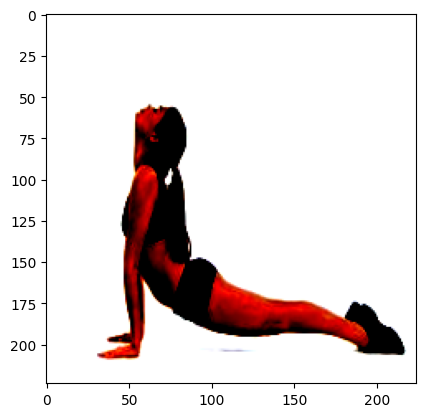

In [5]:
# Display an Image Example
import matplotlib.pyplot as plt
plt.imshow(train_dataset[2345][0].numpy().transpose(1,2,0))

In [6]:
# Create a Sampler to Balance Dataset
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

class_weights = compute_class_weight('balanced', classes=range(max(y_train)+1), y=y_train)
class_weights = 1.0  /torch.tensor(class_weights, dtype=torch.float32)
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#Create model and training parameters
device = config["device"]
batch_size = config["batch_size"]
lr = config["learning_rate"]
betas = config["betas"]
weight_decay = config["weight_decay"]
if config["load_pretrained"] == True:
    model = create_from_pretrained(config)
else:
    model = vit.ViT(config).to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Load a pretrained State or Backbone
#if config["load_pretrained"]:
#    checkpoint = torch.load('model_82_classes.pth')
#
#    #Remove Clasification MLP W and B for Transfer Learning
#    if config["transfer_learning"]:
#        checkpoint['model_state_dict'].pop('cls_layer.weight', None)
#        checkpoint['model_state_dict'].pop('cls_layer.bias', None)
#
#    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

In [9]:
train(model, train_dataloader, optimizer, criterion, scheduler, config)

  0%|          | 0/468 [00:00<?, ?it/s]


AttributeError: 'ViT' object has no attribute 'pos_embedding'

In [ ]:
#checkpoint = torch.load('model_checkpoint_epoch_5.pth')

#model.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

100%|██████████| 936/936 [03:30<00:00,  4.44it/s]


 Accuracy for Validation Dataset: 0.38448183760683763


0.38448183760683763

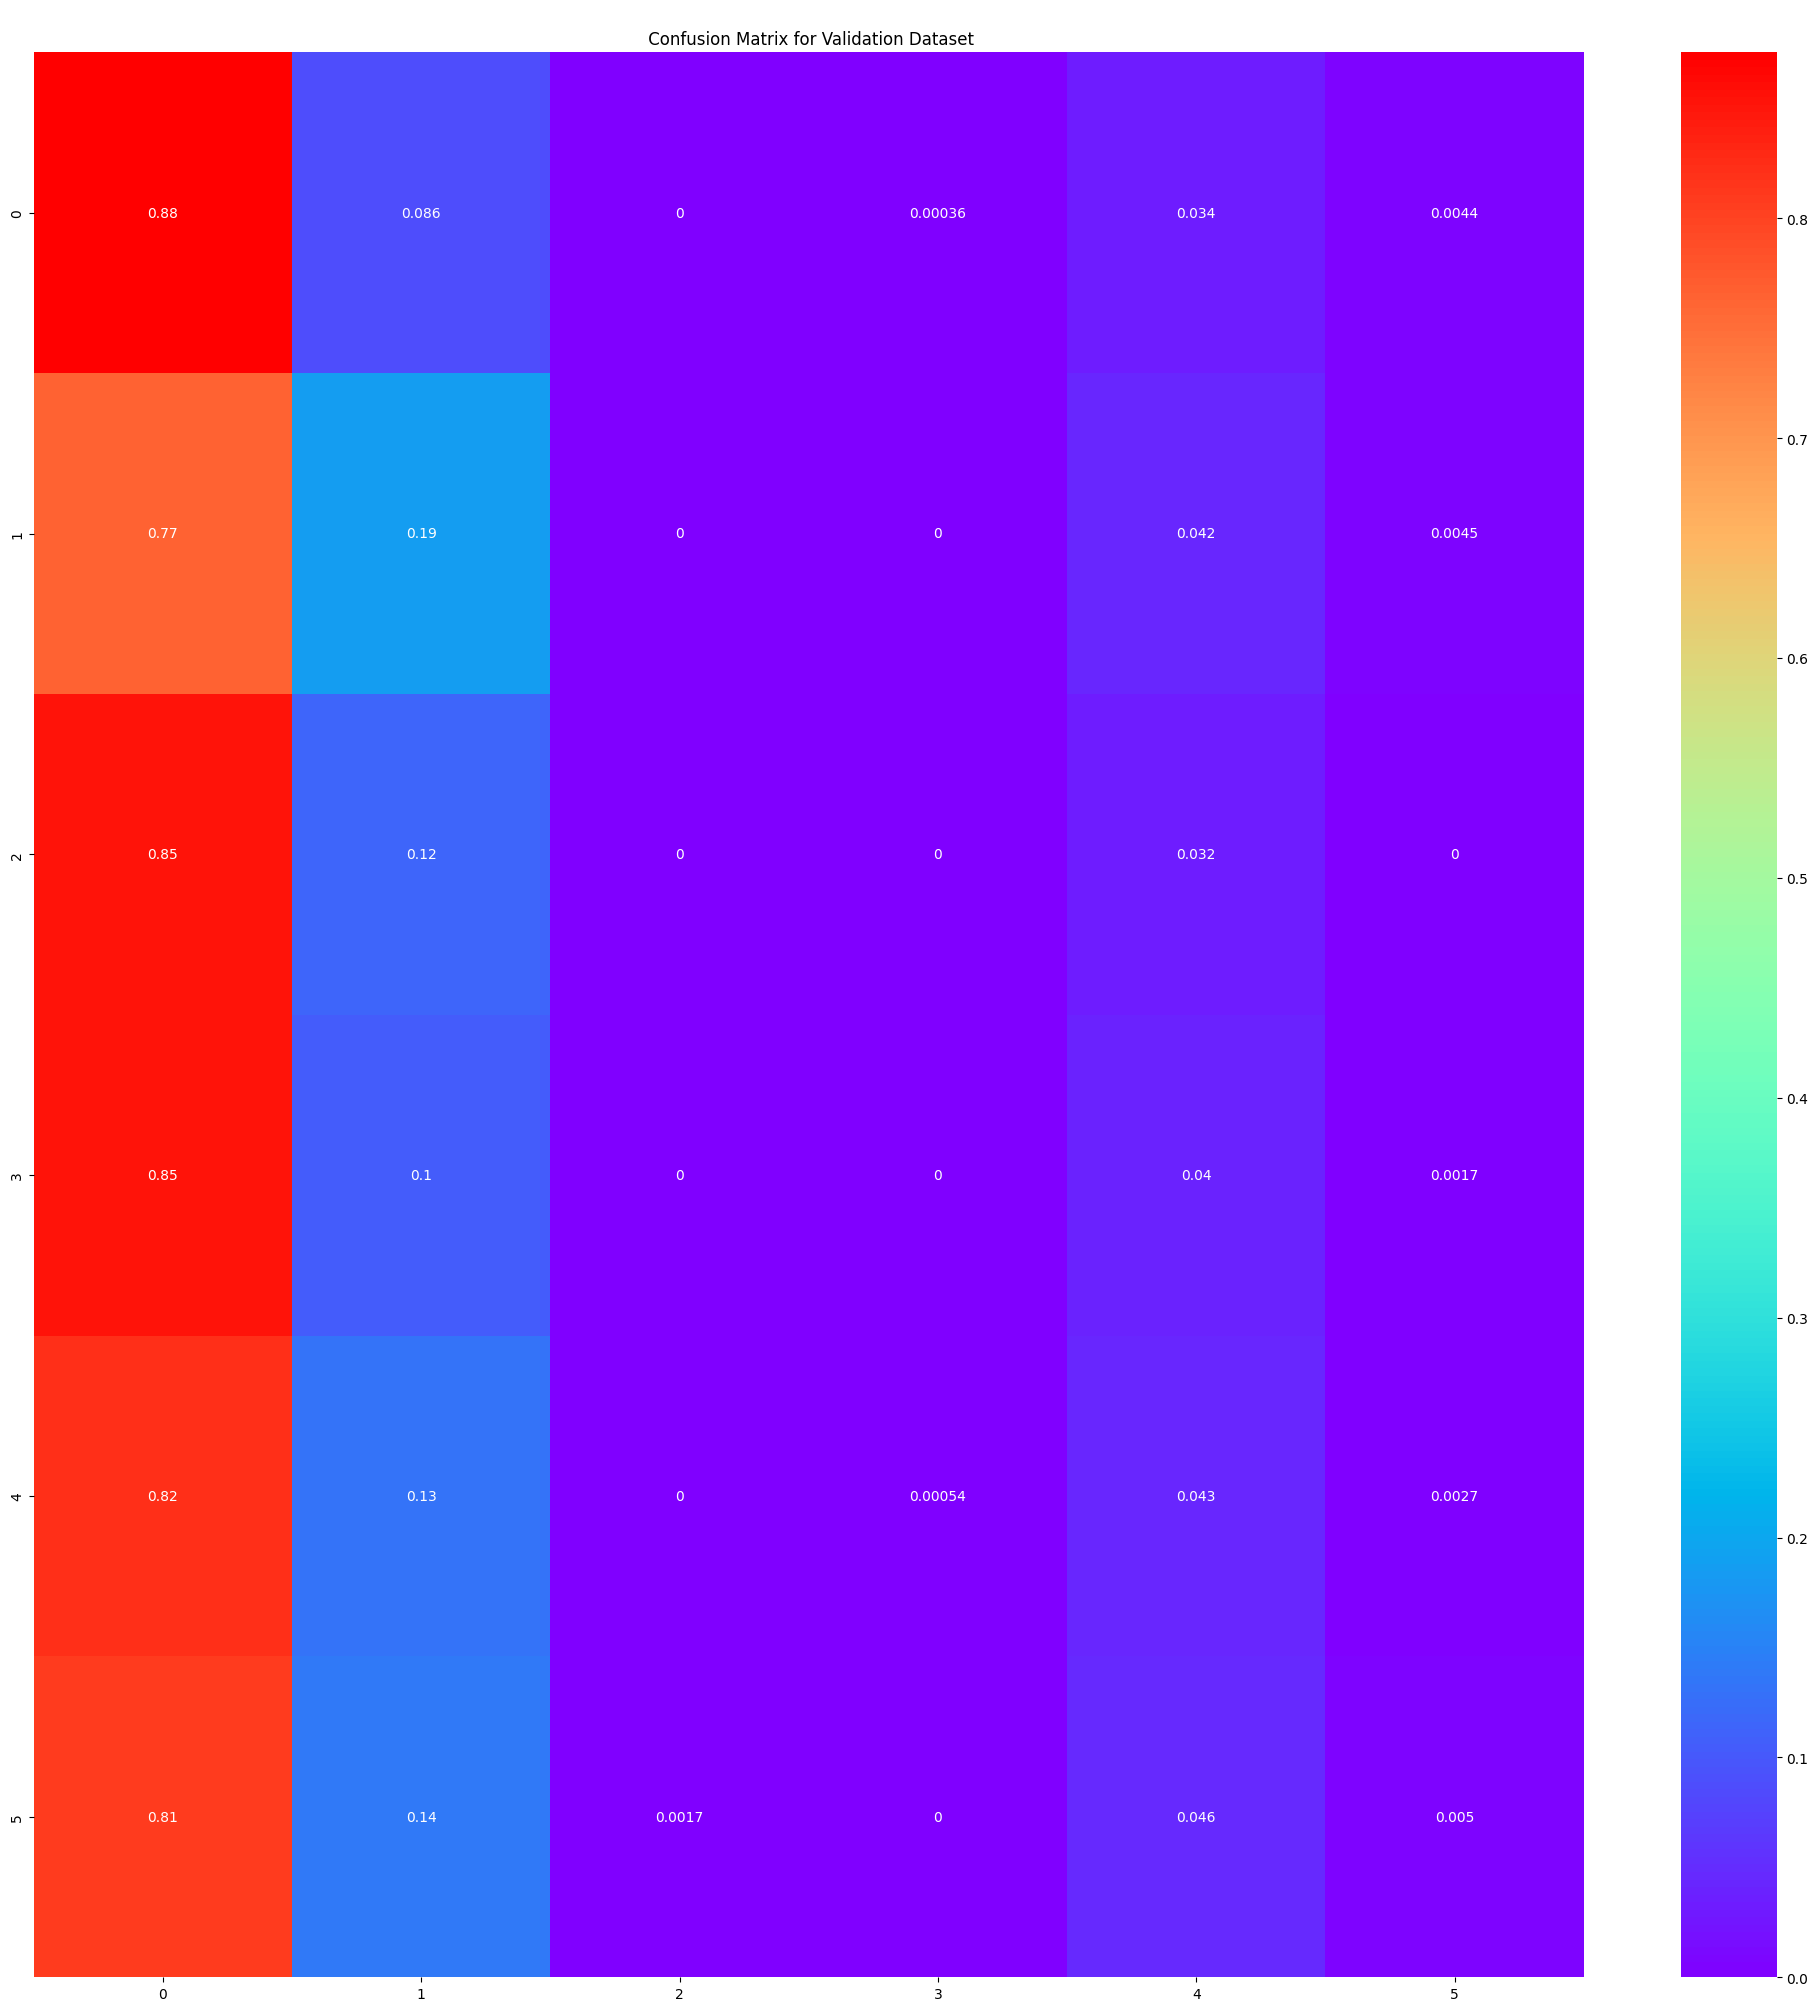

In [ ]:
model_analysis(model, train_dataloader, dataset_name='Train Dataset')